## Compare the likeilhoods generated by LFIAX, SBI (pyknos, maybe), and LAMPE

Starting with the LFIAX likelihood.

In [42]:
from collections import deque
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.lax as lax
import jax.random as jrandom
import numpy as np
import optax
import distrax
import haiku as hk

import tensorflow as tf
import tensorflow_datasets as tfds

from lfiax.flows.nsf import make_nsf

from typing import (
    Any,
    Iterator,
    Mapping,
    Optional,
    Tuple,
)

Array = jnp.ndarray
PRNGKey = Array
Batch = Mapping[str, np.ndarray]
OptState = Any


def sim_linear_jax(d: Array, priors: Array, key: PRNGKey):
    # Keys for the appropriate functions
    keys = jrandom.split(key, 3)

    # sample random normal dist
    noise_shape = (1,)

    mu_noise = jnp.zeros(noise_shape)
    sigma_noise = jnp.ones(noise_shape)

    n_n = distrax.Independent(
        distrax.MultivariateNormalDiag(mu_noise, sigma_noise)
    ).sample(seed=keys[0], sample_shape=[len(d), len(priors)])

    # sample random gamma noise
    n_g = distrax.Gamma(2.0, 1.0 / 2.0).sample(
        seed=keys[1], sample_shape=[len(d), len(priors)]
    )

    # perform forward pass
    y = jnp.broadcast_to(priors[:, 0], (len(d), len(priors)))
    y = y + jnp.expand_dims(d, 1) @ jnp.expand_dims(priors[:, 1], 0)
    y = y + n_g + jnp.squeeze(n_n)
    ygrads = priors[:, 1]

    return y, ygrads


def sim_true_linear_jax(d: Array, theta_true: Array, key: PRNGKey):
    # TODO: check that `theta_true` is the correct size
    # TODO: check that function works as expected
    # Keys for the appropriate functions
    keys = jrandom.split(key, 3)

    # sample random normal dist
    noise_shape = (1,)

    mu_noise = jnp.zeros(noise_shape)
    sigma_noise = jnp.ones(noise_shape)

    n_n = distrax.Independent(
        distrax.MultivariateNormalDiag(mu_noise, sigma_noise)
    ).sample(seed=keys[0], sample_shape=[len(d), len(theta_true)])

    # sample random gamma noise
    n_g = distrax.Gamma(2.0, 1.0 / 2.0).sample(
        seed=keys[1], sample_shape=[len(d), len(theta_true)]
    )

    # perform forward pass
    y = jnp.broadcast_to(theta_true[:, 0], (len(d), len(theta_true)))
    y = y + jnp.expand_dims(d, 1) @ jnp.expand_dims(theta_true[:, 1], 0)
    y = y + n_g + jnp.squeeze(n_n)
    ygrads = theta_true[:, 1]

    return y, ygrads

def sim_linear_prior(num_samples: int, key: PRNGKey):
    """
    Simulate prior samples and return their log_prob.
    """
    theta_shape = (2,)

    mu = jnp.zeros(theta_shape)
    sigma = (3**2) * jnp.ones(theta_shape)

    base_distribution = distrax.Independent(  # Should this be independent?
        distrax.MultivariateNormalDiag(mu, sigma)
    )

    samples, log_prob = base_distribution.sample_and_log_prob(seed=key, sample_shape=[num_samples])

    return samples, log_prob


def sim_data(d: Array, num_samples: Array, key: PRNGKey):
    """
    Returns data in a format suitable for normalizing flow training.
    Data will be in shape [y, thetas, d]. The `y` variable can vary in size.
    """
    keys = jrandom.split(key, 2)

    theta_shape = (2,)

    mu = jnp.zeros(theta_shape)
    sigma = (3**2) * jnp.ones(theta_shape)

    base_distribution = distrax.Independent(  # Should this be independent?
        distrax.MultivariateNormalDiag(mu, sigma)
    )

    priors = base_distribution.sample(seed=keys[0], sample_shape=[num_samples])

    # ygrads allows to be compared to other implementations (Kleinegesse et)
    y, ygrads = sim_linear_jax(d, priors, keys[1])

    return jnp.column_stack(
        (y.T, jnp.squeeze(priors), jnp.broadcast_to(d, (num_samples, len(d))))
    )


def sim_linear_jax_laplace(d: Array, priors: Array, key: PRNGKey):
    # Keys for the appropriate functions
    keys = jrandom.split(key, 3)

    # sample random normal dist
    noise_shape = (1,)

    concentration = jnp.ones(noise_shape)
    rate = jnp.ones(noise_shape)

    n_n = distrax.Gamma(concentration, rate).sample(seed=keys[0], sample_shape=[len(d), len(priors)])

    # perform forward pass
    y = jnp.broadcast_to(priors[:, 0], (len(d), len(priors)))
    y = distrax.MultivariateNormalDiag(y, jnp.squeeze(n_n)).sample(seed=keys[1], sample_shape=())

    return y


def sim_data_laplace(d: Array, priors: Array, key: PRNGKey):
    """
    Returns data in a format suitable for normalizing flow training.
    Data will be in shape [y, thetas]. The `y` variable can vary in size.
    """
    keys = jrandom.split(key, 2)
    theta_shape = (1,)

    loc = jnp.zeros(theta_shape)
    scale = jnp.ones(theta_shape)

    # Leaving in case this fixes future dimensionality issues
    # base_distribution = distrax.Independent(
    #     distrax.Laplace(loc, scale)
    # )
    base_distribution = distrax.Laplace(loc, scale)

    priors = base_distribution.sample(seed=keys[0], sample_shape=[num_samples])

    y = sim_linear_jax_laplace(d, priors, keys[1])

    return jnp.column_stack(
        (y.T, jnp.squeeze(priors), jnp.broadcast_to(d, (num_samples, len(d))))
    )


# ----------------------------------------
# Helper functions to simulate data
# ----------------------------------------
def load_dataset(split: tfds.Split, batch_size: int) -> Iterator[Batch]:
    ds = split
    ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=1000)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))


def prepare_data(batch: Batch, prng_key: Optional[PRNGKey] = None) -> Array:
    # Batch is [y, thetas, d]
    data = batch.astype(np.float32)
    # Handling the scalar case
    if data.shape[1] <= 3:
        x = jnp.expand_dims(data[:, :-2], -1)
    x = data[:, :len_x]
    cond_data = data[:, len_x:]
    theta = cond_data[:, :-len_x]
    d = cond_data[:, -len_x:-len_xi]
    xi = cond_data[:, -len_xi:]
    return x, theta, d, xi


# ----------------------------
# Haiku transform functions for training and evaluation
# ----------------------------
@hk.without_apply_rng
@hk.transform
def log_prob(data: Array, theta: Array, d: Array, xi: Array) -> Array:
    # Get batch
    shift = data.mean(axis=0)
    scale = data.std(axis=0) + 1e-14

    model = make_nsf(
        event_shape=EVENT_SHAPE,
        cond_info_shape=cond_info_shape,
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins,
        standardize_x=True,
        standardize_theta=False,
        use_resnet=True,
        event_dim=EVENT_DIM,
        shift=shift,
        scale=scale,
    )
    return model.log_prob(data, theta, d, xi)


@hk.without_apply_rng
@hk.transform
def model_sample(key: PRNGKey, num_samples: int, cond_data: Array) -> Array:
    # TODO: update this method?
    model = make_nsf(
        event_shape=EVENT_SHAPE,
        cond_info_shape=cond_info_shape,
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins,
    )
    z = jnp.repeat(cond_data, num_samples, axis=0)
    z = jnp.expand_dims(z, -1)
    return model._sample_n(key=key, n=[num_samples], z=z)


def loss_fn(
    params: hk.Params, prng_key: PRNGKey, x: Array, theta: Array, d: Array, xi: Array
) -> Array:
    # Loss is average negative log likelihood.
    loss = -jnp.mean(log_prob.apply(params, x, theta, d, xi))
    return loss


@jax.jit
def eval_fn(params: hk.Params, batch: Batch) -> Array:
    x, theta, d, xi = prepare_data(batch)
    loss = -jnp.mean(log_prob.apply(params, x, theta, d, xi))
    return loss


@jax.jit
def update(
    params: hk.Params, prng_key: PRNGKey, opt_state: OptState, batch: Batch
) -> Tuple[hk.Params, OptState]:
    """Single SGD update step."""
    # x, cond_data = prepare_data(batch, prng_key)
    x, theta, d, xi = prepare_data(batch)
    grads = jax.grad(loss_fn)(params, prng_key, x, theta, d, xi)
    grads_d = jax.grad(loss_fn, argnums=5)(params, prng_key, x, theta, d, xi)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, grads_d


# TODO: Put this in hydra config file
seed = 1231
key = jrandom.PRNGKey(seed)

# d = jnp.array([-10.0, 0.0, 5.0, 10.0])
# d = jnp.array([1., 2.])
# d = jnp.array([1.])
d_obs = jnp.array([0.])
# d_obs = jnp.array([])
# d_prop = jrandom.uniform(key, shape=(1,), minval=-10.0, maxval=10.0)
d_prop = jnp.array([10.])
# d_prop = jnp.array([])
d_sim = jnp.concatenate((d_obs, d_prop), axis=0)
len_x = len(d_sim)
len_d = len(d_obs)
len_xi = len(d_prop)
num_samples = 100

# Params and hyperparams
theta_shape = (2,)
d_shape = (len(d_obs),)
xi_shape = (len_xi,)
EVENT_SHAPE = (len(d_sim),)
# EVENT_DIM is important for the normalizing flow's block.
EVENT_DIM = 1
cond_info_shape = (theta_shape[0], len_d, len_xi)

batch_size = 128
flow_num_layers = 5 #3 # 10
mlp_num_layers = 4 # 3 # 4
hidden_size = 128 # 500
num_bins = 4
learning_rate = 1e-4
warmup_steps = 100
early_stopping_memory = 10
early_stopping_threshold = 5e-2

training_steps = 500
eval_frequency = 10

optimizer = optax.adam(learning_rate)

# Simulating the data to be used to train the flow.
num_samples = 10000
# TODO: put this function in training since d will be changing.
X = sim_data(d_sim, num_samples, key)

shift = X.mean(axis=0)
scale = X.std(axis=0) + 1e-14

# Create tf dataset from sklearn dataset
dataset = tf.data.Dataset.from_tensor_slices(X)

# Splitting into train/validate ds
train = dataset.skip(2000)
val = dataset.take(2000)

# load_dataset(split: tfds.Split, batch_size: int)
train_ds = load_dataset(train, 512)
valid_ds = load_dataset(val, 512)

# Training
prng_seq = hk.PRNGSequence(42)
params = log_prob.init(
    next(prng_seq),
    np.zeros((1, *EVENT_SHAPE)),
    np.zeros((1, *theta_shape)),
    np.zeros((1, *d_shape)),
    np.zeros((1, *xi_shape)),
)
opt_state = optimizer.init(params)

# Can change the length of the deque for more/less leniency in measuring the loss
loss_deque = deque(maxlen=early_stopping_memory)
for step in range(training_steps):
    params, opt_state, grads_d = update(
        params, next(prng_seq), opt_state, next(train_ds)
    )

    if step % eval_frequency == 0:
        val_loss = eval_fn(params, next(valid_ds))
        print(f"STEP: {step:5d}; Validation loss: {val_loss:.3f}")
    
        loss_deque.append(val_loss)
        avg_abs_diff = jnp.mean(abs(jnp.array(loss_deque) - sum(loss_deque)/len(loss_deque)))
        if step > warmup_steps and avg_abs_diff < early_stopping_threshold:
            break


STEP:     0; Validation loss: 9.618
STEP:    10; Validation loss: 9.488
STEP:    20; Validation loss: 9.265
STEP:    30; Validation loss: 9.110
STEP:    40; Validation loss: 9.025
STEP:    50; Validation loss: 8.947
STEP:    60; Validation loss: 8.849
STEP:    70; Validation loss: 8.819
STEP:    80; Validation loss: 8.865
STEP:    90; Validation loss: 8.790
STEP:   100; Validation loss: 8.698
STEP:   110; Validation loss: 8.799
STEP:   120; Validation loss: 8.796
STEP:   130; Validation loss: 8.728
STEP:   140; Validation loss: 8.647
STEP:   150; Validation loss: 8.714
STEP:   160; Validation loss: 8.678
STEP:   170; Validation loss: 8.657
STEP:   180; Validation loss: 8.654


In [2]:
X.shape

(10000, 4)

In [45]:
x = X[:, :2]
y = X[:, 1:3]

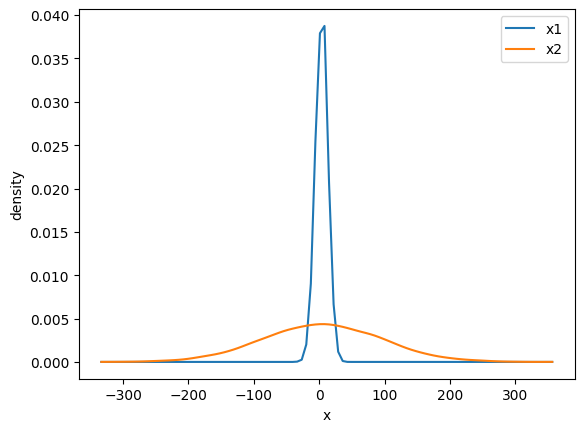

In [46]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# Compute the density
density_1 = gaussian_kde(x[:, 0])
density_2 = gaussian_kde(x[:, 1])

# Plot the density
fig, ax = plt.subplots()
x = np.linspace(jnp.min(x), jnp.max(x), 100)
ax.plot(x, density_1(x), label='x1')
ax.plot(x, density_2(x), label='x2')
plt.xlabel('x')
plt.ylabel('density')
plt.legend()
plt.show()


## Testing LFIAX sampling
Now testing the conditional normalizing flow's sampling.

In [47]:
# TODO: Make code that automatically slices these up.
# theta_test = jnp.expand_dims(X[:, len_x:-len_x], -1)
theta_test = X[:, len_x:-len_x]
# d_test = jnp.expand_dims(X[:, 4], -1)
d_test = X[:, -len_x:-len_xi]
xi_test = X[:, -len_xi:]
# d_test = jnp.expand_dims(theta_test[:, 0], -1)
# xi_test = jnp.expand_dims(theta_test[:, 0], -1)
# xi_test = jnp.expand_dims(X[:, 2], -1)
# xi_test = jnp.ones((10000, 1)) * 3
# xi_test = jnp.expand_dims(X[:, 1], -1)

In [48]:
d_test

DeviceArray([[0.],
             [0.],
             [0.],
             ...,
             [0.],
             [0.],
             [0.]], dtype=float32)

In [57]:
shift = X[:, :2].mean(axis=0)
scale = X[:, :2].std(axis=0) + 1e-14

@hk.without_apply_rng
@hk.transform
def model_sample(key: PRNGKey, num_samples: int, theta: Array, d: Array, xi: Array) -> Array:
# def model_sample(key: PRNGKey, num_samples: int, cond_data: Array) -> Array:
    # TODO: Change cond_data to be the array that the flow expects
    model = make_nsf(
        event_shape=EVENT_SHAPE,
        cond_info_shape=cond_info_shape,
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins,
        standardize_x=True,
        standardize_theta=False,
        use_resnet=True,
        event_dim=EVENT_DIM,
        shift=shift,
        scale=scale,
    )
    return model._sample_n(key=key, n=[num_samples], theta=theta, d=d, xi=xi)


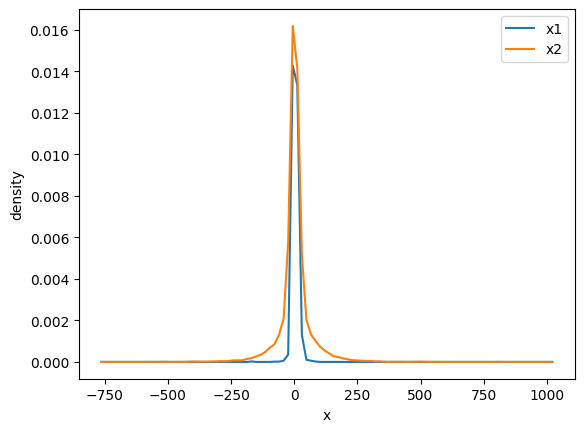

In [58]:
samples = model_sample.apply(params, 
                    next(prng_seq),
                    num_samples=len(theta_test),
                    theta=theta_test,
                    d=d_test,
                    # d=d_obs,
                    xi=xi_test)

density_1 = gaussian_kde(samples[:, 0])
density_2 = gaussian_kde(samples[:, 1])

# Plot the density
fig, ax = plt.subplots()
x = np.linspace(jnp.min(samples), jnp.max(samples), 100)
ax.plot(x, density_1(x), label='x1')
ax.plot(x, density_2(x), label='x2')
plt.xlabel('x')
plt.ylabel('density')
plt.legend()
plt.show()

## Testing Linear Model Simulator

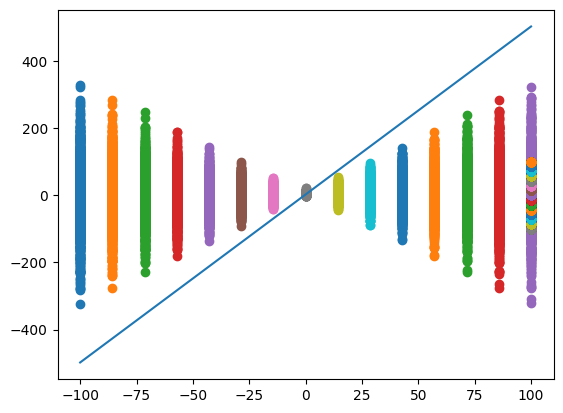

In [5]:
import matplotlib.pyplot as plt

d_sim2 = jnp.linspace(-100, 100, num=15)
num_samples = 1000
x_linear = sim_data(d_sim2, num_samples, key)

y = 2. + 5. * d_sim2
# Plotting
fig, ax = plt.subplots()

ax.plot(d_sim2, y)
for i in range(len(x_linear[0])):
  ax.scatter([d_sim2[i]] * 1000, x_linear[:,i])

## Compare to `pyro` regression model w/ explicit likelihood

In [11]:
import torch
import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro import poutine
from pyro.contrib.util import rmv, lexpand
import numbers

# As a reminder, here's the parameters I used for this linear regression
def sim_linear_jax_laplace(d: Array, priors: Array, key: PRNGKey):
    # Keys for the appropriate functions
    keys = jrandom.split(key, 3)

    # sample random normal dist
    noise_shape = (1,)

    concentration = jnp.ones(noise_shape)
    rate = jnp.ones(noise_shape)

    n_n = distrax.Gamma(concentration, rate).sample(seed=keys[0], sample_shape=[len(d), len(priors)])

    # perform forward pass
    y = jnp.broadcast_to(priors[:, 0], (len(d), len(priors)))
    y = distrax.MultivariateNormalDiag(y, jnp.squeeze(n_n)).sample(seed=keys[1], sample_shape=())
    # y = y + jnp.squeeze(n_n)
    # ygrads = priors[:, 1]

    return y #, ygrads


def sim_data_laplace(d: Array, priors: Array, key: PRNGKey):
    """
    Returns data in a format suitable for normalizing flow training.
    Data will be in shape [y, thetas]. The `y` variable can vary in size.
    """
    keys = jrandom.split(key, 2)
    theta_shape = (1,)

    loc = jnp.zeros(theta_shape)
    scale = jnp.ones(theta_shape)

    # base_distribution = distrax.Independent(  # Should this be independent?
    #     distrax.Laplace(loc, scale)
    # )
    base_distribution = distrax.Laplace(loc, scale)

    priors = base_distribution.sample(seed=keys[0], sample_shape=[num_samples])

    # ygrads allows to be compared to other implementations (Kleinegesse et)
    y = sim_linear_jax_laplace(d, priors, keys[1])

    return jnp.column_stack(
        (y.T, jnp.squeeze(priors), jnp.broadcast_to(d, (num_samples, len(d))))
    )

d_sim2 = jnp.linspace(-100, 100, num=15)

X_laplace = sim_data_laplace(d_sim2, num_samples, key)
X_laplace.shape

(10000, 31)

In [12]:
x_laplace = X_laplace[:,:15]
x_laplace.shape

(10000, 15)

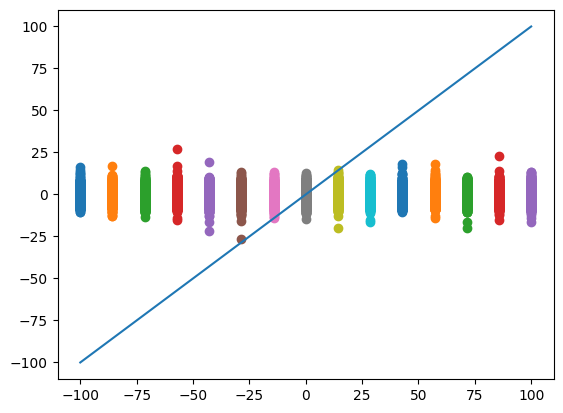

In [13]:
import matplotlib.pyplot as plt

y = 1. * d_sim2
# Plotting
fig, ax = plt.subplots()

ax.plot(d_sim2, y)
for i in range(len(x_laplace[0])):
  ax.scatter([d_sim2[i]] * 10000, x_laplace[:,i])

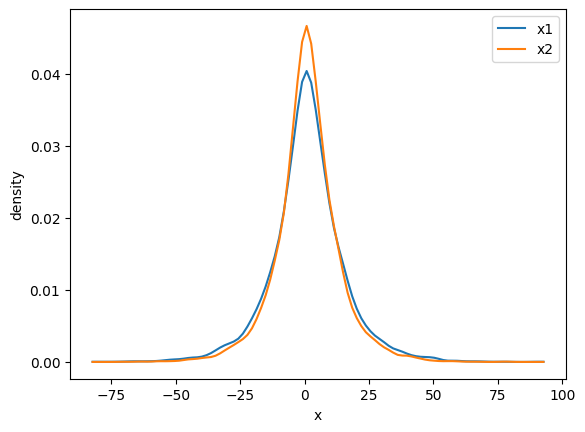

In [107]:
x_laplace = X_laplace[:, :2]
# Compute the density
density_1 = gaussian_kde(x_laplace[:, 0])
density_2 = gaussian_kde(x_laplace[:, 1])

# Plot the density
fig, ax = plt.subplots()
x = np.linspace(jnp.min(x_laplace), jnp.max(x_laplace), 100)
ax.plot(x, density_1(x), label='x1')
ax.plot(x, density_2(x), label='x2')
plt.xlabel('x')
plt.ylabel('density')
plt.legend()
plt.show()


In [6]:
import numpy as np

np_d_sim = np.asarray(d_sim2)
torch_d_sim = torch.from_numpy(np_d_sim).cpu()

device = 'cpu'
scale = 1.
p = 1

w_prior_loc = scale * torch.zeros(p, device=device)
w_prior_scale = scale * torch.ones(p, device=device)
sigma_prior_scale = torch.tensor(1., device=device)


/var/folders/j7/tj9yr2g9655ccsm2fwyzbxv40000gn/T/ipykernel_57186/3076341835.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:205.)
  torch_d_sim = torch.from_numpy(np_d_sim).cpu()


In [7]:
torch_d_sim_expanded = lexpand(torch_d_sim, 10000).unsqueeze(1).unsqueeze(-1)
# torch_d_sim_expanded = lexpand(lexpand(torch_d_sim_expanded, 1), 1)
# design shape needs to be [10, 1, 2, 1]... 
torch_d_sim_expanded.shape

torch.Size([10000, 1, 15, 1])

In [8]:
# design = torch_d_sim_expanded

In [9]:
observation_labels = "y"
target_labels = ["w", "sigma"]
# M = 2

def make_regression_model(w_loc, w_scale, sigma_scale, xi_init, observation_label="y"):
    def regression_model(design_prototype):
        design = pyro.param("xi", xi_init)
        print(design)
        # design = (design / design.norm(dim=-1, p=1, keepdim=True)).expand(design_prototype.shape)
        if is_bad(design):
            raise ArithmeticError("bad design, contains nan or inf")
        batch_shape = design.shape[:-2]
        with pyro.plate_stack("plate_stack", batch_shape):
            # `w` is shape p, the prior on each component is independent
            w = pyro.sample("w", dist.Laplace(w_loc, w_scale).to_event(1))
            print(w.shape)
            # `sigma` is scalar
            sigma = 1e-6 + pyro.sample("sigma", dist.Exponential(sigma_scale)).unsqueeze(-1)
            # print(design)
            mean = rmv(design, w)
            sd = sigma
            y = pyro.sample(observation_label, dist.Normal(mean, sd).to_event(1))
            return y

    return regression_model

def torch_isnan(x):
    """
    A convenient function to check if a Tensor contains any nan; also works with numbers
    """
    if isinstance(x, numbers.Number):
        return x != x
    return torch.isnan(x).any()

def torch_isinf(x):
    """
    A convenient function to check if a Tensor contains any +inf; also works with numbers
    """
    if isinstance(x, numbers.Number):
        return x == float('inf') or x == -float('inf')
    return (x == float('inf')).any() or (x == -float('inf')).any()

def is_bad(a):
    return torch_isnan(a) or torch_isinf(a)

model = make_regression_model(
        w_prior_loc, w_prior_scale, sigma_prior_scale, torch_d_sim_expanded)

with poutine.trace():
    trace = poutine.trace(model).get_trace(torch_d_sim_expanded)
    # y_dict_exp = {l: lexpand(trace.nodes[l]["value"], M) for l in observation_labels}
    y_dict = {l: trace.nodes[l]["value"] for l in observation_labels}
    theta_dict = {l: trace.nodes[l]["value"] for l in target_labels}

tensor([[[[-10.0000],
          [ -8.5714],
          [ -7.1429],
          ...,
          [  7.1429],
          [  8.5714],
          [ 10.0000]]],


        [[[-10.0000],
          [ -8.5714],
          [ -7.1429],
          ...,
          [  7.1429],
          [  8.5714],
          [ 10.0000]]],


        [[[-10.0000],
          [ -8.5714],
          [ -7.1429],
          ...,
          [  7.1429],
          [  8.5714],
          [ 10.0000]]],


        ...,


        [[[-10.0000],
          [ -8.5714],
          [ -7.1429],
          ...,
          [  7.1429],
          [  8.5714],
          [ 10.0000]]],


        [[[-10.0000],
          [ -8.5714],
          [ -7.1429],
          ...,
          [  7.1429],
          [  8.5714],
          [ 10.0000]]],


        [[[-10.0000],
          [ -8.5714],
          [ -7.1429],
          ...,
          [  7.1429],
          [  8.5714],
          [ 10.0000]]]], requires_grad=True)
torch.Size([10000, 1, 1])


In [10]:
y_dict['y'].squeeze().shape

torch.Size([10000, 15])

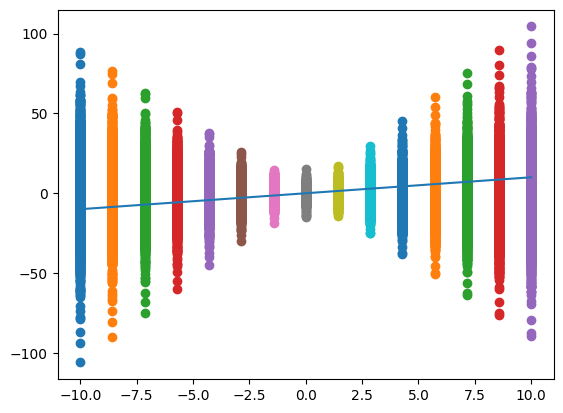

In [14]:
y = 1. * d_sim2
# Plotting
fig, ax = plt.subplots()

ax.plot(d_sim2, y)
for i in range(len(x_laplace[0])):
  ax.scatter([d_sim2[i]] * 10000, y_dict['y'].squeeze().detach().numpy()[:,i])

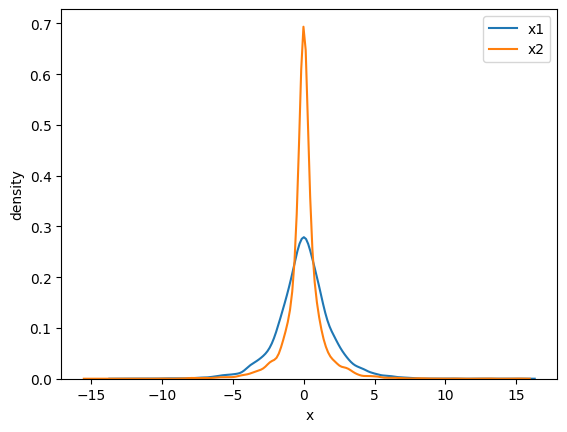

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.kdeplot(y_dict['y'].squeeze().detach().numpy()[:, 0], label='x1')
sns.kdeplot(y_dict['y'].squeeze().detach().numpy()[:, 1], label='x2')
plt.xlabel('x')
plt.ylabel('density')
plt.legend()
plt.show()


In [ ]:
def jax_lexpand(A, *dimensions):
    """Expand tensor, adding new dimensions on left."""
    if jnp.isscalar(A):
        A = A * jnp.ones(dimensions)
        return A
    shape = tuple(dimensions) + A.shape
    A = A[jnp.newaxis, ...]
    A = jnp.broadcast_to(A, shape)
    return A


# Walking through and commenting the code
def lfi_ace_eig_loss(model:NormalizingFlow, guide:NormalizingFlow, 
M, observation_labels, target_labels):
    def loss_fn(design, num_particles, evaluation=False, **kwargs):
        N = num_particles
        # Expand to the number of parallel designs being evaluated
        expanded_design = lexpand(design, N)
        
        # TODO: make a for loop over the proposed models here.
        for model in models:
            # TODO: would be cool to make sampling from the model's prior a method
             # Hmm I need N copies for parallelization. I can figure that out later, though.
            model_thetas_0 = model.prior_distribution.sample(num_samples)
            y_0, log_prob_y_0 = model.sample_with_log_prob(model_thetas_0, expanded_design)
            # Get a dictionary of the expanded y and theta values, just make M copies of y values
            # TODO: think of a better way to add these into expanded dictionary values...
            y_dict_exp = lexpand(y, M)

            # This is essentially the p(y|theta)p(theta)
            # Ohh, each model will have two ratios, it's current prob and its prior one
            marginal_terms_cross = sum(model.prior_distribution.log_prob(model_thetas_0))
            marginal_terms_cross += sum(log_prob_y_0)

        # Pray that jax can handle this parallelization - vmap and pmap to the rescue!...?
        for _ in range(m):
            for model in models:
                # Sample from q(theta | y, d) using the guide normalizing flow
                theta, log_prob = guide.sample_with_log_prob(y, expanded_design, observation_labels, target_labels)
                theta_y_dict = {l: theta[l] for l in target_labels}
                theta_y_dict.update(y_dict_exp)

                marginal_terms_proposal = -sum(log_prob[l] for l in target_labels)
                marginal_terms_proposal += sum(log_prob[l] for l in target_labels)
                marginal_terms_proposal += sum(log_prob[l] for l in observation_labels)

                marginal_terms = torch.cat([lexpand(marginal_terms_cross, 1), marginal_terms_proposal])
                terms = -marginal_terms.logsumexp(0) + math.log(M + 1)

                # At eval time, add p(y | theta, d) terms
                if evaluation:
                    terms += sum(log_prob[l] for l in observation_labels)
                return _safe_mean_terms(terms)

        # Sample from q(theta | y, d) using the guide normalizing flow
        theta, log_prob = guide.sample_with_log_prob(y, expanded_design, observation_labels, target_labels)
        theta_y_dict = {l: theta[l] for l in target_labels}
        theta_y_dict.update(y_dict_exp)

        marginal_terms_proposal = -sum(log_prob[l] for l in target_labels)
        marginal_terms_proposal += sum(log_prob[l] for l in target_labels)
        marginal_terms_proposal += sum(log_prob[l] for l in observation_labels)

        marginal_terms = torch.cat([lexpand(marginal_terms_cross, 1), marginal_terms_proposal])
        terms = -marginal_terms.logsumexp(0) + math.log(M + 1)

        # At eval time, add p(y | theta, d) terms
        if evaluation:
            terms += sum(log_prob[l] for l in observation_labels)
        return _safe_mean_terms(terms)

    return loss_fn


## Regular ACE
Really just copy/paste of AF's implementation in `pyro`. Since the current `pyro` release doesn't have some of AF's code from SGBOED, have to copy/paste some of his custom functions here.

Going to compare the lower/upper bounds of SGBOED on a simple linear regression task. 

In [ ]:
import time
import numbers
import math

import torch
from torch import nn
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro import poutine
from pyro.contrib.util import rmv, lexpand

def is_bad(a):
    return torch_isnan(a) or torch_isinf(a)
    

def torch_isnan(x):
    """
    A convenient function to check if a Tensor contains any nan; also works with numbers
    """
    if isinstance(x, numbers.Number):
        return x != x
    return torch.isnan(x).any()


def torch_isinf(x):
    """
    A convenient function to check if a Tensor contains any +inf; also works with numbers
    """
    if isinstance(x, numbers.Number):
        return x == float('inf') or x == -float('inf')
    return (x == float('inf')).any() or (x == -float('inf')).any()


def _safe_mean_terms(terms):
    mask = torch.isnan(terms) | (terms == float('-inf')) | (terms == float('inf'))
    if terms.dtype is torch.float32:
        nonnan = (~mask).sum(0).float()
    elif terms.dtype is torch.float64:
        nonnan = (~mask).sum(0).double()
    terms[mask] = 0.
    loss = terms.sum(0) / nonnan
    agg_loss = loss.sum()
    return agg_loss, loss


def make_regression_model(w_loc, w_scale, sigma_scale, xi_init, observation_label="y"):
    def regression_model(design_prototype):
        design = pyro.param("xi", xi_init)
        design = (design / design.norm(dim=-1, p=1, keepdim=True)).expand(design_prototype.shape)
        if is_bad(design):
            raise ArithmeticError("bad design, contains nan or inf")
        batch_shape = design.shape[:-2]
        with pyro.plate_stack("plate_stack", batch_shape):
            # `w` is shape p, the prior on each component is independent
            w = pyro.sample("w", dist.Laplace(w_loc, w_scale).to_event(1))
            # `sigma` is scalar
            sigma = 1e-6 + pyro.sample("sigma", dist.Exponential(sigma_scale)).unsqueeze(-1)
            mean = rmv(design, w)
            sd = sigma
            y = pyro.sample(observation_label, dist.Normal(mean, sd).to_event(1))
            return y

    return regression_model


class TensorLinear(nn.Module):
    __constants__ = ['bias']

    def __init__(self, *shape, bias=True):
        super(TensorLinear, self).__init__()
        self.in_features = shape[-2]
        self.out_features = shape[-1]
        self.batch_dims = shape[:-2]
        self.weight = nn.Parameter(torch.Tensor(*self.batch_dims, self.out_features, self.in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(*self.batch_dims, self.out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        return rmv(self.weight, input) + self.bias


class PosteriorGuide(nn.Module):
    def __init__(self, y_dim, w_dim, batching):
        super(PosteriorGuide, self).__init__()
        n_hidden = 64
        self.linear1 = TensorLinear(*batching, y_dim, n_hidden)
        self.linear2 = TensorLinear(*batching, n_hidden, n_hidden)
        self.output_layer = TensorLinear(*batching, n_hidden, w_dim + 3)
        self.covariance_shape = batching + (w_dim, w_dim)
        self.softplus = nn.Softplus()
        self.relu = nn.ReLU()

    def forward(self, y_dict, design_prototype, observation_labels, target_labels):
        y = y_dict["y"] - .5
        x = self.relu(self.linear1(y))
        x = self.relu(self.linear2(x))
        final = self.output_layer(x)

        posterior_mean = final[..., :-3]
        gamma_concentration = 1e-6 + self.softplus(final[..., -3])
        gamma_rate = 1. + self.softplus(final[..., -2])
        scale_tril_multiplier = 1e-6 + self.softplus(final[..., -1])

        pyro.module("posterior_guide", self)

        posterior_scale_tril = pyro.param(
            "posterior_scale_tril",
            torch.eye(posterior_mean.shape[-1], device=posterior_mean.device).expand(self.covariance_shape),
            constraint=constraints.lower_cholesky
        )
        posterior_scale_tril = posterior_scale_tril * scale_tril_multiplier.unsqueeze(-1).unsqueeze(-1)

        batch_shape = design_prototype.shape[:-2]
        with pyro.plate_stack("guide_plate_stack", batch_shape):
            pyro.sample("sigma", dist.Gamma(gamma_concentration, gamma_rate))
            pyro.sample("w", dist.MultivariateNormal(posterior_mean, scale_tril=posterior_scale_tril))


def _ace_eig_loss(model, guide, M, observation_labels, target_labels):
    def loss_fn(design, num_particles, evaluation=False, **kwargs):
        N = num_particles
        expanded_design = lexpand(design, N)
        
        # Sample from p(y, theta | d)
        trace = poutine.trace(model).get_trace(expanded_design)
        y_dict_exp = {l: lexpand(trace.nodes[l]["value"], M) for l in observation_labels}
        y_dict = {l: trace.nodes[l]["value"] for l in observation_labels}
        theta_dict = {l: trace.nodes[l]["value"] for l in target_labels}

        trace.compute_log_prob()
        marginal_terms_cross = sum(trace.nodes[l]["log_prob"] for l in target_labels)
        marginal_terms_cross += sum(trace.nodes[l]["log_prob"] for l in observation_labels)

        reguide_trace = poutine.trace(
            pyro.condition(guide, data=theta_dict)).get_trace(
            y_dict, expanded_design, observation_labels, target_labels)
        # Here's a spot where you could update each model's parameters based on log_prob
        reguide_trace.compute_log_prob()
        marginal_terms_cross -= sum(reguide_trace.nodes[l]["log_prob"] for l in target_labels)

        # Sample M times from q(theta | y, d) for each y
        reexpanded_design = lexpand(expanded_design, M)
        guide_trace = poutine.trace(guide).get_trace(
            y_dict, reexpanded_design, observation_labels, target_labels
        )
        theta_y_dict = {l: guide_trace.nodes[l]["value"] for l in target_labels}
        theta_y_dict.update(y_dict_exp)
        guide_trace.compute_log_prob()

        # Re-run that through the model to compute the joint
        model_trace = poutine.trace(
            pyro.condition(model, data=theta_y_dict)).get_trace(reexpanded_design)
        model_trace.compute_log_prob()

        marginal_terms_proposal = -sum(guide_trace.nodes[l]["log_prob"] for l in target_labels)
        marginal_terms_proposal += sum(model_trace.nodes[l]["log_prob"] for l in target_labels)
        marginal_terms_proposal += sum(model_trace.nodes[l]["log_prob"] for l in observation_labels)

        marginal_terms = torch.cat([lexpand(marginal_terms_cross, 1), marginal_terms_proposal])
        terms = -marginal_terms.logsumexp(0) + math.log(M + 1)

        # At eval time, add p(y | theta, d) terms
        if evaluation:
            terms += sum(trace.nodes[l]["log_prob"] for l in observation_labels)
        return _safe_mean_terms(terms)

    return loss_fn


def neg_loss(loss):
    def new_loss(*args, **kwargs):
        return (-a for a in loss(*args, **kwargs))
    return new_loss


def opt_eig_loss_w_history(design, loss_fn, num_samples, num_steps, optim, time_budget):
    params = None
    est_loss_history = []
    xi_history = []
    baseline = 0.
    t = time.time()
    wall_times = []
    for step in range(num_steps):
        if params is not None:
            pyro.infer.util.zero_grads(params)
        with poutine.trace(param_only=True) as param_capture:
            agg_loss, loss = loss_fn(design, num_samples, evaluation=True, control_variate=baseline)
        baseline = -loss.detach()
        params = set(site["value"].unconstrained()
                     for site in param_capture.trace.nodes.values())
        if torch.isnan(agg_loss):
            raise ArithmeticError("Encountered NaN loss in opt_eig_ape_loss")
        agg_loss.backward(retain_graph=True)
        est_loss_history.append(loss.detach())
        wall_times.append(time.time() - t)
        optim(params)
        optim.step()
        print(pyro.param("xi")[0, 0, ...])
        print(step)
        print('eig', baseline.squeeze())
        if time_budget and time.time() - t > time_budget:
            break

    xi_history.append(pyro.param('xi').detach().clone())

    est_loss_history = torch.stack(est_loss_history)
    xi_history = torch.stack(xi_history)
    wall_times = torch.tensor(wall_times)

    return xi_history, est_loss_history, wall_times


# --------------------
# Start Pyro code implementation
num_steps = 1000
num_samples = 10
time_budget = 1000
seed = 420
num_parallel = 1
start_lr = 0.001
end_lr = 0.001
device = 'cpu'
n = 20
p = 1
scale = 1.

pyro.clear_param_store()
if seed >= 0:
    pyro.set_rng_seed(seed)
else:
    seed = int(torch.rand(tuple()) * 2 ** 30)
    pyro.set_rng_seed(seed)

xi_init = torch.randn((num_parallel, n, p), device=device)
# Change the prior distribution here
# prior params
w_prior_loc = torch.zeros(p, device=device)
w_prior_scale = scale * torch.ones(p, device=device)
sigma_prior_scale = scale * torch.tensor(1., device=device)

model_learn_xi = make_regression_model(
    w_prior_loc, w_prior_scale, sigma_prior_scale, xi_init)

contrastive_samples = num_samples

# Fix correct loss
targets = ["w", "sigma"]

guide = PosteriorGuide(n, p, (num_parallel,)).to(device)
eig_loss = _ace_eig_loss(model_learn_xi, guide, contrastive_samples, ["y"], targets)
loss = neg_loss(eig_loss)

gamma = (end_lr / start_lr) ** (1 / num_steps)
scheduler = pyro.optim.ExponentialLR({'optimizer': torch.optim.Adam, 'optim_args': {'lr': start_lr},
                                        'gamma': gamma})

design_prototype = torch.zeros(num_parallel, n, p, device=device)  # this is annoying, code needs refactor

xi_history, est_loss_history, wall_times = opt_eig_loss_w_history(
    design_prototype, loss, num_samples=num_samples, num_steps=num_steps, optim=scheduler,
    time_budget=time_budget)

est_eig_history = -est_loss_history

results = {'seed': seed, 'xi_history': xi_history.cpu(), 'est_eig_history': est_eig_history.cpu(),
            'wall_times': wall_times.cpu()}